# Revised Baseline Model

# Import Modules

In [27]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')


# Load Data

In [28]:
# load the provided data
train_features = pd.read_csv('../data/dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('../data/dengue_labels_train.csv',
                           index_col=[0,1,2])

# Split Data

In [29]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [30]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


# Feature Engineering

In [31]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

# Check for Missing Values

In [32]:
# Null check
pd.isnull(sj_train_features).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

# Plot to Check Missing Values

Text(0.5, 0, 'Time')

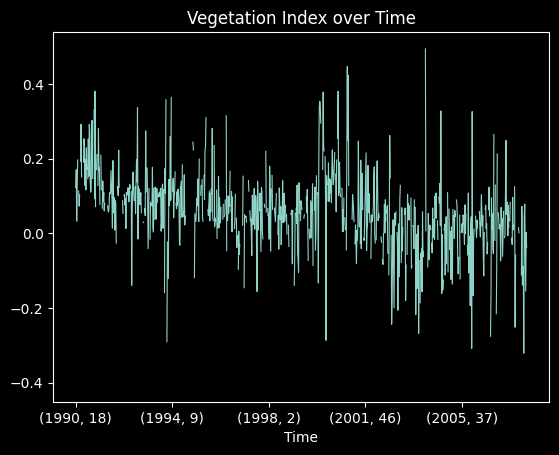

In [33]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

# Fill Missing Values

Replace `NA` values with most recent value

In [34]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

# Plot to Check Filled Values

Text(0.5, 0, 'Time')

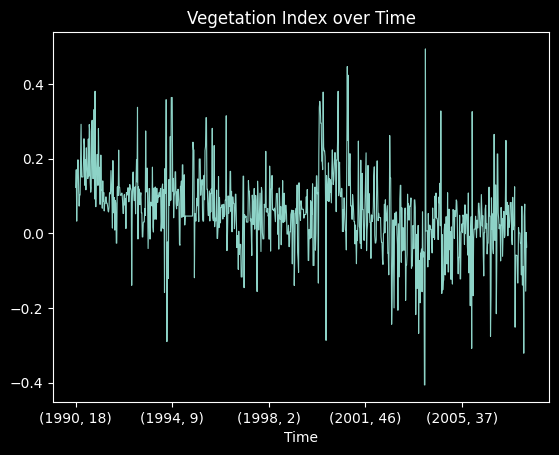

In [35]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

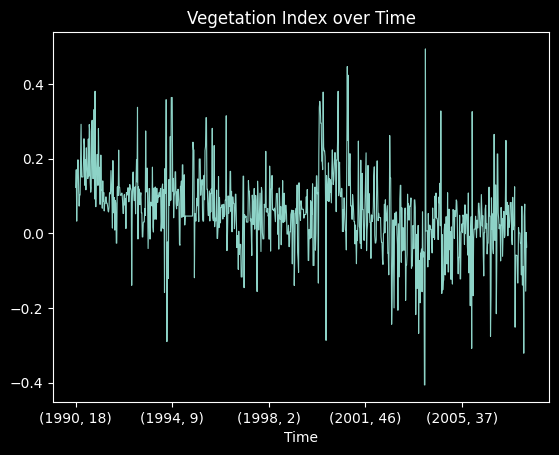

In [36]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

# Choose Model

- Poisson regression: assumes mean and variance of population distributions are equal
- Negative binomial regression: preferred if the variance is much larger than the mean

The variance is larger than the mean for both cities, so we'll use Negative Binomial Regression.

In [37]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


# Plot Target Values

array([[<Axes: title={'center': 'total_cases'}>]], dtype=object)

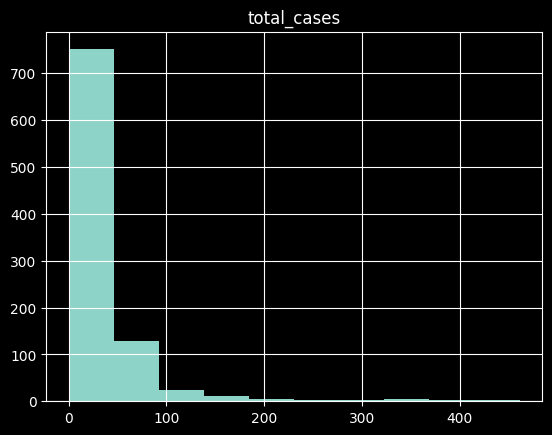

In [38]:
sj_train_labels.hist()

array([[<Axes: title={'center': 'total_cases'}>]], dtype=object)

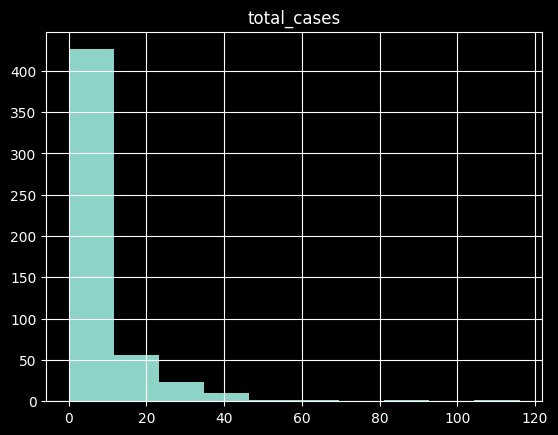

In [39]:
iq_train_labels.hist()

# Find Features vs Target Correlations

## Add Target to Features DataFrames

In [40]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

## Plot Correlation Heatmaps

In [41]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

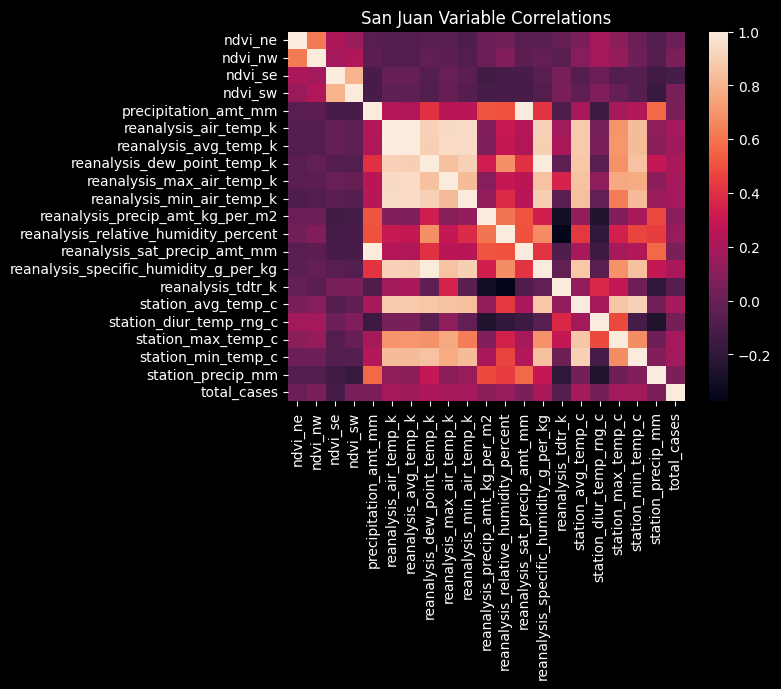

In [42]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

Text(0.5, 1.0, 'Iquitos Variable Correlations')

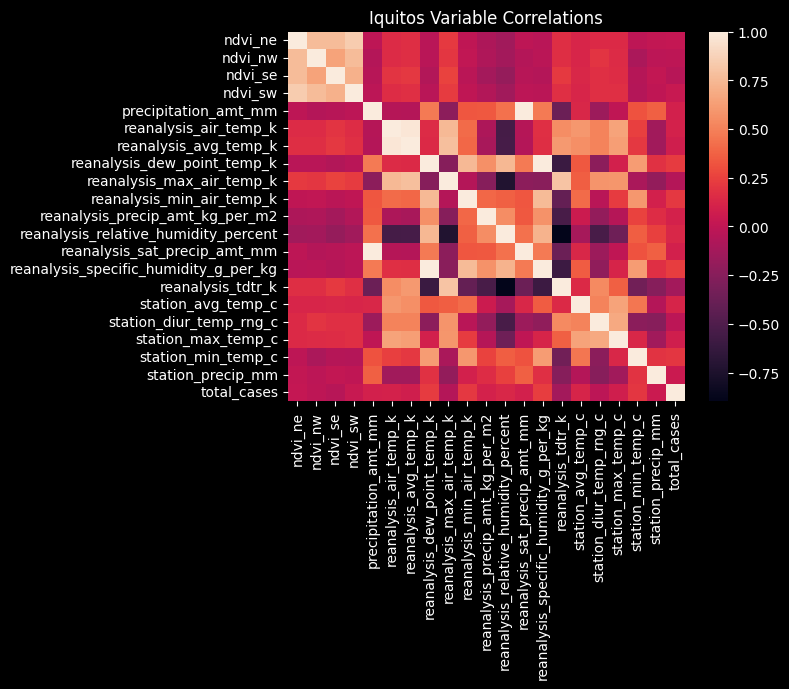

In [43]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

## Bar Plots of Correlations

<Axes: >

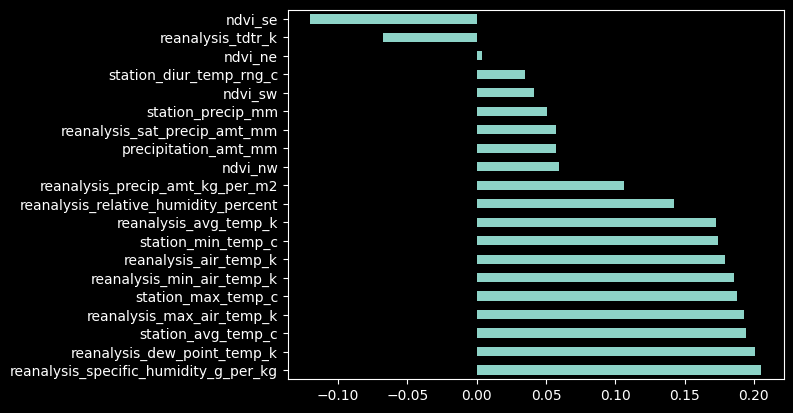

In [44]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh()) # horizontal bar plot

<Axes: >

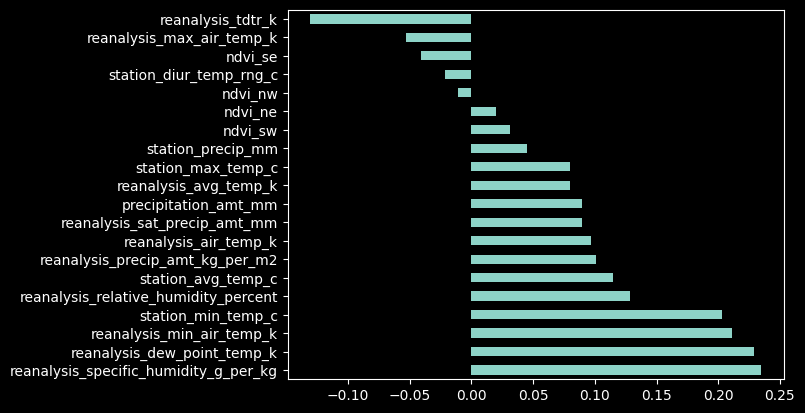

In [45]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh()) # horizontal bar plot

# Observations

Wet and warm climates are correlated with cases of Dengue fever.

- `reanalysis_specific_humidity_g_per_kg` and `reanalysis_dew_point_temp_k` are most strongly correlated with `total_cases`
- `reanalysis_min_air_temp` and `station_min_temp` are also strongly correlated with `total_cases`

We'll use these features for our model!

# Preprocess Data

We create a smaller dataset to train our model.

In [46]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [47]:
sj_train, iq_train = preprocess_data('../data/dengue_features_train.csv',
                                    labels_path="../data/dengue_labels_train.csv")

In [48]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,34.180556
std,1.560663,1.570075,1.415079,1.506281,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.233571,293.843929,25.842857,21.700000,9.000000
50%,16.835000,295.451429,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [49]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.102019,295.498723,27.506331,21.210385,7.565385
std,1.443048,1.414360,0.908973,1.257734,10.765478
min,12.111429,290.088571,21.400000,14.700000,0.000000
25%,16.121429,294.596429,26.957500,20.600000,1.000000
50%,17.428571,295.852143,27.587500,21.400000,5.000000
75%,18.180357,296.557143,28.075000,22.000000,9.000000
max,20.461429,298.450000,30.800000,24.200000,116.000000


# Split Datasets

For a time series model, we'll use a strict-future holdout (validation) set when splitting our train set and test set.

In [50]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

# Fit Model on Training Set

We'll use a **Negative Binomial Regression** model, suitable for **count** data, where the **variance is larger than the mean**.

This function finds the best model parameters using a Generalized Linear Model (`GLM`) with a Negative Binomial distribution.

This is particularly useful in epidemiology for modeling **count** data that follows a distribution with **over-dispersion**, meaning the variance is greater than the mean, which is a common occurrence in infectious disease counts.

While it can model over-dispersed count data better than Poisson regression, it is less flexible in capturing complex nonlinear relationships compared to Random Forest, used for our first baseline model.

To evaluate the performance of the model, we again use the Mean Absolutel Error (`MAE`) between the predicted and actual total cases. The `alpha` value that results in the lowest `MAE` is considered the best. The `alpha` value is the over-dispersion parameter. The best model is then refitted on the entire dataset.

For the first dataset (San Juan), the best score, or the lowest `MAE` achieved, was approximately `22.08`, while for the second dataset (Iquitos), it was approximately `6.47`. These scores give an indication of how far off the predictions are from the actual values, on average, in terms of the total number of cases.

In [51]:
def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  22.080882352941178
best alpha =  1e-08
best score =  6.466666666666667


# Evaluate Model: Plot Predicted vs Actual Cases

We can notice the following from the plots below:

- The model does seem to predict the seasonal patterns in Dengue cases
- The model does not predict the spikes in cases

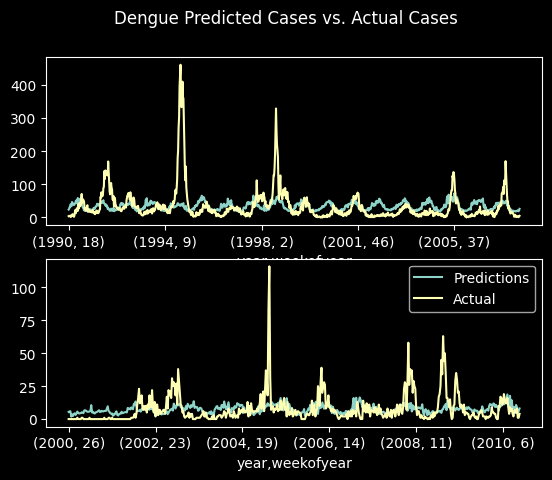

In [52]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

# Make Third Submission

We made our third submission to DrivenData using this revised pipeline and received a Mean Absolute Error (`MAE`) score of `25.8173`.

In the context of our model, which predicts total cases of Dengue fever, an `MAE` of `25.8173` means that, on average, our predictions are about `25.8173` cases away from the actual number of cases.

So, despite the changes made to this pipeline between the first and second submissions, our third and final model did not improve on our first and second submissions! Our best score was `25.6875` using a **Random Forest** regressor.

In [53]:
sj_test, iq_test = preprocess_data('../data/dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("../data/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("../submissions/benchmark.csv")

# Reflections

The main differences between our first and second attempts and this third and final attempt were:

- We filled `NA` values with most recent values in the time series
- We **split** the data set between cities, San Juan and Iquitos
- We used a **Negative Binomial** regression model

While we made several fundamental changes to our pipeline, our best score was for our second attempting, using a Random Forest regressor.

Given these results, it appears that while our model performed reasonably well on the validation set, there's a discrepancy between the validation `MAE` and the score on the test set, which is more than double. This could be due to several reasons:

- **Overfitting to the validation set**: Our model might have learned specific patterns in the validation set that don't generalize to the test set.
- **Differences between validation and test sets**: If the test set contains different patterns or a different distribution of cases, this could lead to a higher error rate.
- **Model Limitations**: The model may not capture all the complexities of the data, or there may be influential features or interactions that the model is not considering.

## Future Work

To improve our model, we could consider the following steps:

- **Feature Engineering**: Create new features or transform existing ones to better capture the relationships in the data.
- **Hyperparameter Tuning**: Optimize the model's hyperparameters to improve performance.
- **Cross-Validation**: Implement **k-fold cross-validation** to ensure that the model's performance is consistent across different subsets of the data.
- **Ensemble Methods**: Combine different models to improve predictions and reduce the likelihood of overfitting.
- **Leakage Check**: Ensure there's no leakage of information from the test set into the training process.